In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import blackjack as bj
from blackjack import Hand, HandScore, Action, make_hand
import simulator as sim

In [2]:
h = HandScore(11, True)
h

s11

In [3]:
h.add_card(10)

s21

In [4]:
h.add_card(10).add_card(10)

h21

In [5]:
h

s11

In [6]:
h.add_card(3)

s14

In [7]:
h.add_card(3).add_card(10)

h14

In [8]:
all_scores = [HandScore(i, False) for i in range(0, 23)] + [HandScore(i, True) for i in range(11, 22)]
all_scores

[h00,
 h01,
 h02,
 h03,
 h04,
 h05,
 h06,
 h07,
 h08,
 h09,
 h10,
 h11,
 h12,
 h13,
 h14,
 h15,
 h16,
 h17,
 h18,
 h19,
 h20,
 h21,
 h22,
 s11,
 s12,
 s13,
 s14,
 s15,
 s16,
 s17,
 s18,
 s19,
 s20,
 s21]

In [9]:
h = Hand()
h

Hand(score=h00, cards=[], doubled=False, drawn=False)

In [10]:
h.add_card(6) # start a hand with a 6

Hand(score=h06, cards=[6], doubled=False, drawn=True)

In [11]:
h.add_card(11) # show that J (11) counts as 10 points

Hand(score=h16, cards=[6, 11], doubled=False, drawn=True)

In [12]:
h.add_card(7), bj.is_busted(h) # bust (show that 23 is counted as 22)

(Hand(score=h22, cards=[6, 11, 7], doubled=False, drawn=True), True)

In [13]:
# OK, now let's try another hand with aces
h = Hand()
h.add_card(1) # should be a soft 11

Hand(score=s11, cards=[1], doubled=False, drawn=True)

In [14]:
h.add_card(1) # two aces: should be a soft 12

Hand(score=s12, cards=[1, 1], doubled=False, drawn=True)

In [15]:
h.add_card(11) # two aces and a J: should be a hard 12

Hand(score=h12, cards=[1, 1, 11], doubled=False, drawn=True)

In [16]:
# OK, now let's try another hand with a blackjack
h = Hand()
h.add_card(1) # should be a soft 11
h.add_card(10)
h, bj.is_blackjack(h)

(Hand(score=s21, cards=[1, 10], doubled=False, drawn=True), True)

## Now define gameplay and strategy

In [17]:
[bj.deal_card() for _ in range(10)]

[4, 13, 7, 4, 9, 3, 11, 5, 6, 1]

In [18]:
bj.play_one_round([bj.strat_nobust, bj.strat_nobust])

[('strat_nobust',
  Hand(score=h16, cards=[4, 2, 11], doubled=False, drawn=True),
  Hand(score=h19, cards=[12, 5, 4], doubled=False, drawn=True),
  <HandOutcome.LOSE: -1>),
 ('strat_nobust',
  Hand(score=h12, cards=[4, 2, 6], doubled=False, drawn=True),
  Hand(score=h19, cards=[12, 5, 4], doubled=False, drawn=True),
  <HandOutcome.LOSE: -1>)]

## Aggregate and summarize the data from the simulations

In [19]:


strat_nobust = bj.strat_nobust
strat_dealer = bj.strat_dealer
sim.generate_rows_from_round(bj.play_one_round([bj.strat_nobust, bj.strat_dealer]))


[{'strategy': 'strat_nobust',
  'hand_start': [3, 13],
  'dealer_card': 1,
  'hand_end': [3, 13],
  'dealer_hand': [1, 11],
  'outcome': <HandOutcome.LOSE: -1>},
 {'strategy': 'strat_dealer',
  'hand_start': [3, 13],
  'dealer_card': 1,
  'hand_end': [3, 13, 2, 6],
  'dealer_hand': [1, 11],
  'outcome': <HandOutcome.LOSE: -1>}]

In [20]:


sim_results = sim.run_n_sim_trials([strat_nobust, strat_dealer], 10000)
#%prun -s cumulative sim_results, sim.summarize_totals(sim_results)

In [21]:
def strat_simple(score_p, score_d):
    if score_p.points == 11:  return Action.DOUBLE
    if score_p.points >= 17:  return Action.STAND
    if score_p.points <= 11:  return Action.HIT
    if score_d.points in (range(3,7)):  return Action.STAND
    else:  return Action.HIT
        
strat_simple.name = 'simple'


sims = sim.run_n_sim_trials([strat_simple], 1000)
sims.head(10), sim.summarize_totals(sims)

(  strategy hand_start  dealer_card         hand_end    dealer_hand  \
 0   simple    [12, 6]           13       [12, 6, 5]  [13, 2, 3, 8]   
 1   simple   [12, 11]            9         [12, 11]      [9, 2, 8]   
 2   simple     [9, 5]           13       [9, 5, 10]       [13, 11]   
 3   simple    [11, 7]           13          [11, 7]        [13, 9]   
 4   simple     [6, 8]           10       [6, 8, 13]    [10, 2, 12]   
 5   simple    [10, 1]            3          [10, 1]     [3, 7, 13]   
 6   simple     [4, 3]            4        [4, 3, 6]     [4, 8, 10]   
 7   simple    [5, 11]            8       [5, 11, 8]     [8, 2, 12]   
 8   simple     [9, 6]           10        [9, 6, 2]       [10, 11]   
 9   simple     [1, 5]           10  [1, 5, 3, 3, 9]        [10, 8]   
 
                  outcome  outcome_value outcome_name  
 0        HandOutcome.WIN            1.0          WIN  
 1        HandOutcome.WIN            1.0          WIN  
 2       HandOutcome.LOSE           -1.0         

In [22]:
%prun -s cumulative sim.summarize_totals(sim.run_n_sim_trials([strat_dealer, strat_nobust, strat_simple], 10000))


## Simulate specific situations to determine strategy

In [23]:
# 12 vs deuce

hand_p = make_hand([5, 7])
hand_d = make_hand([2])

hand_p, hand_d

(Hand(score=h12, cards=[5, 7], doubled=False, drawn=True),
 Hand(score=h02, cards=[2], doubled=False, drawn=True))

In [24]:
# Implement a strategy that composes conditions and actions

def cond_12_2(score_p, score_d):
    return score_p.points == 12 and score_d.points == 2 and not score_p.soft
conditions = [(cond_12_2, Action.STAND)]


    
strat_cond = sim.generate_strat_conditional(strat_simple, conditions)
strat_cond

<function simulator.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>

In [25]:
# Generate a conditional strategy for each action
    
strats = sim.gen_cond_strategies(strat_simple, cond_12_2, [Action.HIT, Action.STAND, Action.DOUBLE])
strats

[<function simulator.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function simulator.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function simulator.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>]

In [26]:
bj.complete_one_round(strats, hand_p, hand_d, bj.deal_card())

[('<Action.HIT: 2>',
  Hand(score=h18, cards=[5, 7, 6], doubled=False, drawn=True),
  Hand(score=h20, cards=[2, 12, 8], doubled=False, drawn=True),
  <HandOutcome.LOSE: -1>),
 ('<Action.STAND: 1>',
  Hand(score=h12, cards=[5, 7], doubled=False, drawn=True),
  Hand(score=h20, cards=[2, 12, 8], doubled=False, drawn=True),
  <HandOutcome.LOSE: -1>),
 ('<Action.DOUBLE: 3>',
  Hand(score=h20, cards=[5, 7, 8], doubled=False, drawn=True),
  Hand(score=h20, cards=[2, 12, 8], doubled=False, drawn=True),
  <HandOutcome.PUSH: 0>)]

In [27]:


sims = sim.run_n_sim_trials_from_state(strats, hand_p, hand_d, 10000)
sim.summarize_totals(sims)

len            mean_outcome
outcome_name        LOSE PUSH   WIN             
strategy                                        
<Action.DOUBLE: 3>  6150  684  3166      -0.2984
<Action.HIT: 2>     6171  657  3172      -0.2999
<Action.STAND: 1>   6468    0  3532      -0.2936

In [28]:
# Soft 12 vs 2
hand_12s = make_hand([1, 1])

hand_12s, hand_d

(Hand(score=s12, cards=[1, 1], doubled=False, drawn=True),
 Hand(score=h02, cards=[2], doubled=False, drawn=True))

In [29]:
def cond_12s_2(score_p, score_d):
    return score_p == HandScore(12, True) and score_d.points == 2

strats = sim.gen_cond_strategies(strat_simple, cond_12s_2, [Action.HIT, Action.STAND, Action.DOUBLE])
strats

[<function simulator.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function simulator.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function simulator.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>]

In [30]:
sims = sim.run_n_sim_trials_from_state(strats+[strat_simple], hand_12s, hand_d, 10000)
sim.summarize_totals(sims)

len            mean_outcome
outcome_name        LOSE PUSH   WIN             
strategy                                        
<Action.DOUBLE: 3>  5278  835  3887      -0.1391
<Action.HIT: 2>     5259  825  3916      -0.1343
<Action.STAND: 1>   6358    0  3642      -0.2716
simple              5218  810  3972      -0.1246

In [31]:
sim.summarize_totals(sim.run_n_sim_trials_from_state([strat_simple, strat_cond], hand_p, hand_d, 10*1000))

len            mean_outcome
outcome_name  LOSE PUSH   WIN             
strategy                                  
simple        6106  645  3249      -0.2857
strat_cond    6299    0  3701      -0.2598

In [32]:
# soft 13 vs 6
def cond_13s_6(score_p, score_d):
    return score_p == HandScore(13, True) and score_d.points == 6



strats = sim.gen_cond_strategies(strat_simple, cond_13s_6, [Action.HIT, Action.STAND, Action.DOUBLE])
sims = sim.run_n_sim_trials_from_state(strats+[strat_simple], bj.make_hand([1, 2]), bj.make_hand([6]), 10000)
sim.summarize_totals(sims)

len            mean_outcome
outcome_name        LOSE PUSH   WIN             
strategy                                        
<Action.DOUBLE: 3>  4807  292  4901       0.0094
<Action.HIT: 2>     4845  290  4865       0.0020
<Action.STAND: 1>   5747    0  4253      -0.1494
simple              5747    0  4253      -0.1494

In [33]:
# 10 v 6
def cond_10_6(score_p, score_d):
    return score_p.points == 10 and score_d.points == 6

strats = sim.gen_cond_strategies(strat_simple, cond_10_6, [Action.HIT, Action.STAND, Action.DOUBLE])
sims = sim.run_n_sim_trials_from_state(strats+[strat_simple], make_hand([5, 5]), make_hand([6]), 10000)
sim.summarize_totals(sims)

len            mean_outcome
outcome_name        LOSE PUSH   WIN             
strategy                                        
<Action.DOUBLE: 3>  3249  691  6060       0.2811
<Action.HIT: 2>     3193  701  6106       0.2913
<Action.STAND: 1>   5793    0  4207      -0.1586
simple              3220  696  6084       0.2864

In [34]:
sim.test_cond(HandScore(10), HandScore(6), 10000, strat_simple)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                      len                                   mean_outcome
 outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
 strategy                                                               
 <Action.DOUBLE: 3>     0        3295  672     0       6033       0.5476
 <Action.HIT: 2>     3258           0  697  6045          0       0.2787
 <Action.STAND: 1>   5757           0    0  4243          0      -0.1514)

In [35]:
sim.test_cond(HandScore(18), HandScore(6), 200, strat_simple)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0         154    5    0         41       -1.130
 <Action.HIT: 2>     165           0    5   30          0       -0.675
 <Action.STAND: 1>    57           0   13  130          0        0.365)

In [36]:
sim.test_cond(HandScore(21, True), HandScore(6), 200, strat_simple)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0          74   18    0        108         0.34
 <Action.HIT: 2>      71           0   20  109          0         0.19
 <Action.STAND: 1>     0           0   18  182          0         0.91)

In [37]:

sim.find_winning_action(HandScore(10), HandScore(6), 200)

{'<Action.DOUBLE: 3>': 0.56,
 '<Action.HIT: 2>': 0.27,
 '<Action.STAND: 1>': -0.11,
 'score_p': 'h10',
 'score_d': 'h06',
 'winning_act': <Action.DOUBLE: 3>,
 'winning_act_outcome': 0.56}

In [38]:
sim.test_cond(HandScore(18), HandScore(11, True), 1000)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0         862   23    0        115       -1.494
 <Action.HIT: 2>     830           0   28  142          0       -0.688
 <Action.STAND: 1>   590           0  126  284          0       -0.306)

In [39]:
%prun -s cumulative conds = sim.compute_instructions(20)
pd.DataFrame(conds).set_index(['score_p', 'score_d'])

<Action.DOUBLE: 3>  <Action.HIT: 2>  <Action.STAND: 1>  \
score_p score_d                                                           
h09     s11                    -0.3           -0.050              -0.40   
        h02                     0.2            0.000              -0.30   
        h03                    -0.2            0.100              -0.30   
        h04                     0.7            0.450               0.20   
        h05                     0.4            0.050              -0.20   
...                             ...              ...                ...   
s21     h06                     0.5            0.300               0.80   
        h07                     0.2            0.400               1.00   
        h08                    -0.2            0.300               0.95   
        h09                    -0.1           -0.200               0.90   
        h10                    -0.9           -0.125               0.90   

                   winning_act  winning_act_outcome  
score_p score_d                                      
h09     s11         Action.HIT                -0.05  
        h02      Action.DOUBLE                 0.20  
        h03         Action.HIT                 0.10  
        h04      Action.DOUBLE                 0.70  
        h05      Action.DOUBLE                 0.40  
...                        ...                  ...  
s21     h06       Action.STAND                 0.80  
        h07       Action.STAND                 1.00  
        h08       Action.STAND                 0.95  
        h09       Action.STAND                 0.90  
        h10       Action.STAND                 0.90  

[250 rows x 5 columns]

In [40]:

%prun -s cumulative sim.compute_instructions(100, strat_simple)

In [41]:
def run_iteration(n, strat_base, previous_instructions):
    comput = sim.compute_instructions(n, strat_base)
    outputs = pd.DataFrame(comput).set_index(['score_p', 'score_d'])
    
    instructions = {(output['score_p'], output['score_d']): output['winning_act'] for output in comput}
    
    fig = plt.figure()
    # Visualize the winning action by starting condition
    sns.heatmap(outputs['winning_act'].apply(lambda x: x.value).unstack(), ax=fig.add_subplot(1, 2, 1))
    
    # Visualize the average outcome by starting condition
    sns.heatmap(outputs['winning_act_outcome'].unstack(), ax=fig.add_subplot(1, 2, 2))
    
    if previous_instructions:
        for k in instructions:
            if instructions[k] != previous_instructions[k]:
                print(k, instructions[k], previous_instructions[k])
    
    return instructions

#%prun -s cumulative run_iteration(1, strat_simple, None)

In [42]:
# Memoized strategy
# Rather than generic conditions, just use an array indexed on player and dealer scores
# Since that's how we're generating our strategy anyway (one square at a time)

def gen_strat_memoized(instructions, strat_base):
    def strat_memoized(score_p, score_d):
        k = (repr(score_p), repr(score_d))
        if k in instructions:
            return instructions[k]
        else:
            return strat_base(score_p, score_d)
    strat_memoized.name = 'memoized'
    return strat_memoized

instructions = {(repr(HandScore(13, True)), repr(HandScore(6))): Action.HIT}
strat_memoized = gen_strat_memoized(instructions, strat_simple)

sims = sim.run_n_sim_trials([strat_simple, strat_memoized], 1000)
sims.head(10), sim.summarize_totals(sims)

(   strategy hand_start  dealer_card      hand_end dealer_hand  \
 0    simple    [10, 5]            1    [10, 5, 7]     [1, 10]   
 1  memoized    [10, 5]            1   [10, 5, 11]     [1, 10]   
 2    simple     [2, 6]            9    [2, 6, 10]     [9, 13]   
 3  memoized     [2, 6]            9  [2, 6, 3, 8]     [9, 13]   
 4    simple   [11, 10]            5      [11, 10]  [5, 12, 3]   
 5  memoized   [11, 10]            5      [11, 10]  [5, 12, 3]   
 6    simple     [4, 8]           12    [4, 8, 11]    [12, 12]   
 7  memoized     [4, 8]           12     [4, 8, 6]    [12, 12]   
 8    simple    [1, 10]            5       [1, 10]  [5, 13, 8]   
 9  memoized    [1, 10]            5       [1, 10]  [5, 13, 8]   
 
                  outcome  outcome_value outcome_name  
 0       HandOutcome.LOSE           -1.0         LOSE  
 1       HandOutcome.LOSE           -1.0         LOSE  
 2       HandOutcome.LOSE           -1.0         LOSE  
 3       HandOutcome.PUSH            0.0        

0
1
('h09', 'h03') Action.DOUBLE Action.HIT
('h09', 'h07') Action.HIT Action.DOUBLE
('h10', 'h04') Action.DOUBLE Action.HIT
('h10', 'h09') Action.DOUBLE Action.HIT
('h10', 'h10') Action.HIT Action.DOUBLE
('h11', 's11') Action.HIT Action.DOUBLE
('h11', 'h04') Action.DOUBLE Action.HIT
('h11', 'h09') Action.HIT Action.DOUBLE
('h12', 'h02') Action.STAND Action.HIT
('h12', 'h03') Action.HIT Action.STAND
('h12', 'h04') Action.HIT Action.DOUBLE
('h12', 'h05') Action.STAND Action.DOUBLE
('h12', 'h07') Action.HIT Action.DOUBLE
('h13', 'h06') Action.HIT Action.STAND
('h13', 'h08') Action.HIT Action.STAND
('h14', 'h03') Action.DOUBLE Action.STAND
('h14', 'h04') Action.STAND Action.HIT
('h14', 'h05') Action.STAND Action.DOUBLE
('h14', 'h08') Action.HIT Action.STAND
('h15', 's11') Action.HIT Action.STAND
('h15', 'h03') Action.HIT Action.STAND
('h15', 'h08') Action.STAND Action.HIT
('h15', 'h09') Action.STAND Action.HIT
('h15', 'h10') Action.HIT Action.STAND
('h16', 'h08') Action.HIT Action.STAND
('

[<function __main__.strat_simple(score_p, score_d)>,
 <function __main__.gen_strat_memoized.<locals>.strat_memoized(score_p, score_d)>,
 <function __main__.gen_strat_memoized.<locals>.strat_memoized(score_p, score_d)>,
 <function __main__.gen_strat_memoized.<locals>.strat_memoized(score_p, score_d)>,
 <function __main__.gen_strat_memoized.<locals>.strat_memoized(score_p, score_d)>,
 <function __main__.gen_strat_memoized.<locals>.strat_memoized(score_p, score_d)>]

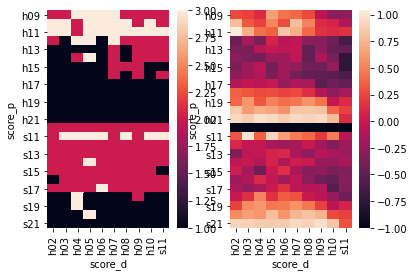

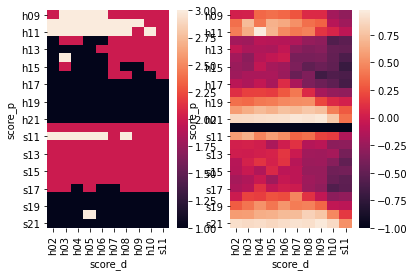

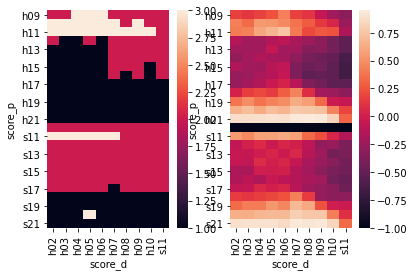

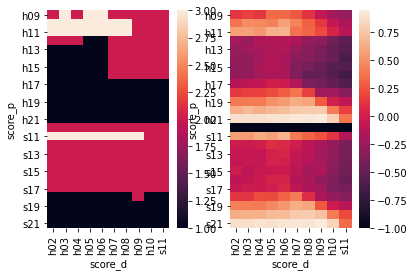

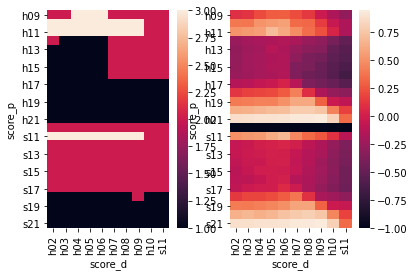

In [43]:
n = 50
strat_base = strat_simple
previous_instructions = None
strategies = [strat_simple]

for i in range(5):
    print(i)
    instructions = run_iteration(n, strat_base, previous_instructions)
    strat_new  = gen_strat_memoized(instructions, strat_base)
    strat_new.name = f'iter({i+1})'
    strategies.append(strat_new)
    previous_instructions = instructions
    strat_base = strat_new
    n = n*3

strategies

In [44]:
sims = sim.run_n_sim_trials(strategies, 1000*1000)
sims.head(10), sim.summarize_totals(sims)

(  strategy hand_start  dealer_card     hand_end  dealer_hand  \
 0   simple    [13, 6]            2  [13, 6, 11]  [2, 10, 11]   
 1  iter(1)    [13, 6]            2      [13, 6]  [2, 10, 11]   
 2  iter(2)    [13, 6]            2      [13, 6]  [2, 10, 11]   
 3  iter(3)    [13, 6]            2      [13, 6]  [2, 10, 11]   
 4  iter(4)    [13, 6]            2      [13, 6]  [2, 10, 11]   
 5  iter(5)    [13, 6]            2      [13, 6]  [2, 10, 11]   
 6   simple    [12, 9]            1      [12, 9]       [1, 6]   
 7  iter(1)    [12, 9]            1      [12, 9]       [1, 6]   
 8  iter(2)    [12, 9]            1      [12, 9]       [1, 6]   
 9  iter(3)    [12, 9]            1      [12, 9]       [1, 6]   
 
             outcome  outcome_value outcome_name  
 0  HandOutcome.LOSE           -1.0         LOSE  
 1   HandOutcome.WIN            1.0          WIN  
 2   HandOutcome.WIN            1.0          WIN  
 3   HandOutcome.WIN            1.0          WIN  
 4   HandOutcome.WIN        